# Tutorial 5: Estimating black hole masses

In [2]:
import pandas as pd
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('bmh')

In [3]:
data_shen = pd.read_csv('shen_subsample_500.csv')
data_SDSS = pd.read_csv('cross_matched_new.csv')
data_shen

,RAJ2000,DEJ2000,Plate,Fiber,MJD,iMAG,logLbol,e_logLbol,logLBHb,e_logLBHb,W_BHb_,e_W_BHb_,EWBHb,e_EWBHb,SN_Hb_,logBH,e_logBH,logEdd
0,189.67804,45.30687,1372,486,53062,-23.20,45.236,0.004,42.35,0.02,4399.3,330.1,62.0,3.1,23.06,8.33,0.07,-1.20
1,189.77188,41.44564,1984,609,53433,-22.29,44.819,0.005,42.11,0.04,2371.4,541.6,89.4,8.7,15.06,7.59,0.20,-0.87
2,189.81419,53.23740,885,449,52379,-22.69,45.121,0.004,41.93,0.04,10756.6,4366.4,32.1,3.4,16.27,9.05,0.35,-2.03
3,189.93733,19.90707,2614,350,54481,-23.37,45.132,0.001,42.55,0.02,15241.3,362.8,118.7,6.3,19.79,9.36,0.02,-2.33
4,189.99405,49.09448,1278,96,52735,-22.77,45.166,0.011,42.25,0.01,1385.6,48.6,52.5,2.9,15.96,7.29,0.03,-0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,231.08040,27.95578,1846,28,54173,-23.33,45.423,0.005,42.56,0.02,9345.2,348.3,60.6,3.4,24.76,9.08,0.03,-1.76
496,231.09229,26.70657,2160,444,53885,-22.72,44.989,0.005,42.19,0.04,4363.7,503.4,73.2,6.8,17.34,8.20,0.10,-1.31
497,231.11946,30.54376,1650,545,53174,-24.56,45.891,0.001,43.14,0.01,2572.5,106.9,76.1,1.9,40.15,8.19,0.04,-0.40
498,231.12225,35.25613,1354,466,52814,-22.60,45.143,0.005,41.80,0.05,1559.7,243.2,21.0,2.7,15.44,7.38,0.14,-0.34


### Make diagnostic plots

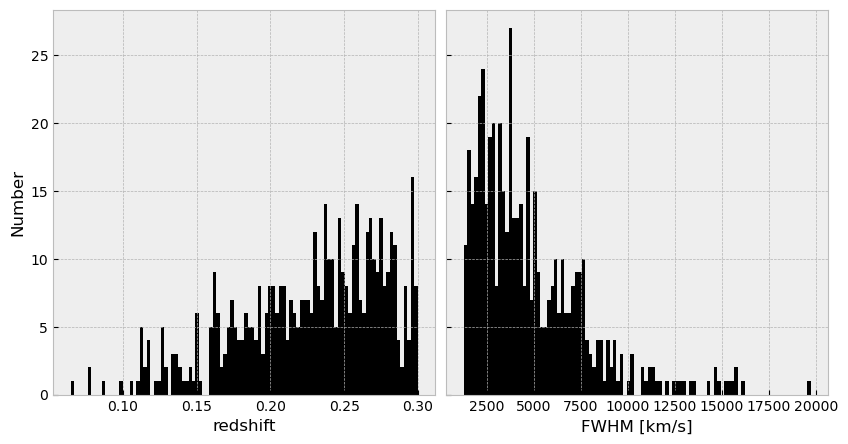

In [4]:
fig = plt.figure(figsize = (10,5))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.03)
(ax1, ax2) = gs.subplots(sharey=True)

ax1.hist(data_SDSS["redshift"], bins = 100, color = 'black')
ax1.set_xlabel('redshift')
ax1.set_ylabel('Number')

ax2.hist(data_shen["W_BHb_"], bins = 100, color = 'black')
ax2.set_xlabel('FWHM [km/s]')
plt.show()

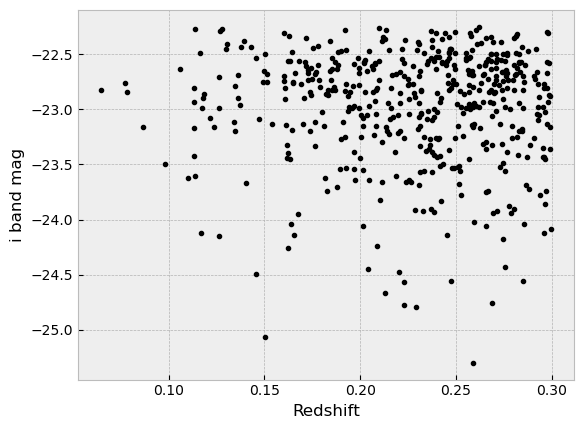

In [5]:
plt.plot(data_SDSS['redshift'], data_shen['iMAG'], 'k.')
plt.xlabel('Redshift')
plt.ylabel('i band mag')
plt.show()

In [6]:
H0=67.8
omega_m=0.31
omega_l=0.69
c = 299792.458
Dh =  c / H0 #units Mpc

In [7]:
from scipy.integrate import quad
def integrand(z, omega_m, omega_l): 
    return 1/(np.sqrt((omega_m * (1 + z) ** 3) + omega_l))
def lum_dist(z, omega_m, omega_l):
    I = quad(integrand, 0, z, args=(omega_m,omega_l))
    dl = Dh * I[0] * (1 + z)
    return dl
    
Dl = []

for index, row in data_SDSS.iterrows():
    dl = lum_dist(row['redshift'], omega_m, omega_l)
    Dl.append(dl)
    
data_SDSS['Lum dist'] = Dl
#data_SDSS

Ned Wright's cosmology calculator gives 654.7 Mpc for the first object (same as we get) so we are doing it right! A lot of cosmological calculators have python implementation these days so I hope I never have to do this manualy again.

Let's think about units. According to the schema browser the units of h_beta_flux are 1e-17 erg/s/cm^2. Lum dist units are Mpc. We want to get luminisity in erg/s so we need to make a conversion for Mpc to cm (or the other way around, doesn't matter). 1 Mpc = 3.086e+24 cm.

In [8]:
lum_hb = 4 * np.pi * data_SDSS['Hbeta flux'] * 1e-17 * (data_SDSS['Lum dist'] * 3.086e+24) ** 2
data_SDSS['Hbeta lum'] = lum_hb

#data_SDSS

Now, to use the formula directly we want the luminosity in ergs (already ensured) and the FWHM in km per s (Shen paper says that's already the case).

In [9]:
M_bh = 2.4e6 * (data_SDSS['Hbeta lum'] / 1e42) ** 0.59 * (data_shen['W_BHb_'] / 1e3) ** 2

data_SDSS['Mass of BH'] = M_bh
#data_SDSS

We get black hole masses that make physical sense, which is always good. The empirical relation we used lays on the assumption that the gas around the black hole is virialised and the broad line region clouds are isotropically distributed. 

In [10]:
l_bol = 10 ** (0.94 * np.log10(data_SDSS['Hbeta lum']) + 5.39)

data_SDSS['Lum bol'] = l_bol
#data_SDSS

Eddington luminosity is $L_{Edd} = 1.26 \times 10^{38} \times \left(\frac{M}{M_{\odot}}\right) \text{erg/s}$ according to wikipedia. Those are the most easy to use units in our case.

In [11]:
L_edd = 1.26e38 * data_SDSS['Mass of BH']         #in erg/s

data_SDSS['Edd lum'] = L_edd
#data_SDSS

In [12]:
data_SDSS['Edd ratio'] = data_SDSS['Lum bol'] / data_SDSS['Edd lum']
#data_SDSS

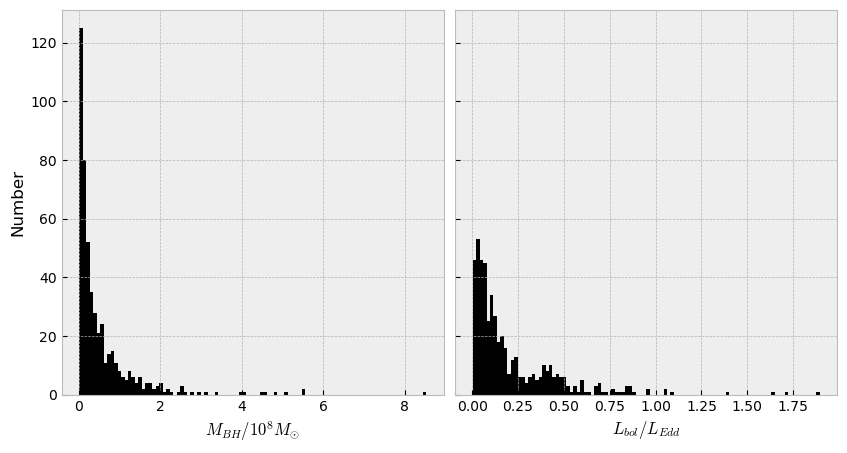

In [13]:
fig = plt.figure(figsize = (10,5))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.03)
(ax1, ax2) = gs.subplots(sharey=True)

ax1.hist(data_SDSS['Mass of BH'] / 1e8, bins = 100, color = 'black')
ax1.set_xlabel(r'$M_{BH}/10^8 M_{\odot}$')
ax1.set_ylabel('Number')

ax2.hist(data_SDSS['Edd ratio'], bins = 100, color = 'black')
ax2.set_xlabel(r'$L_{bol}/L_{Edd}$')
plt.show()

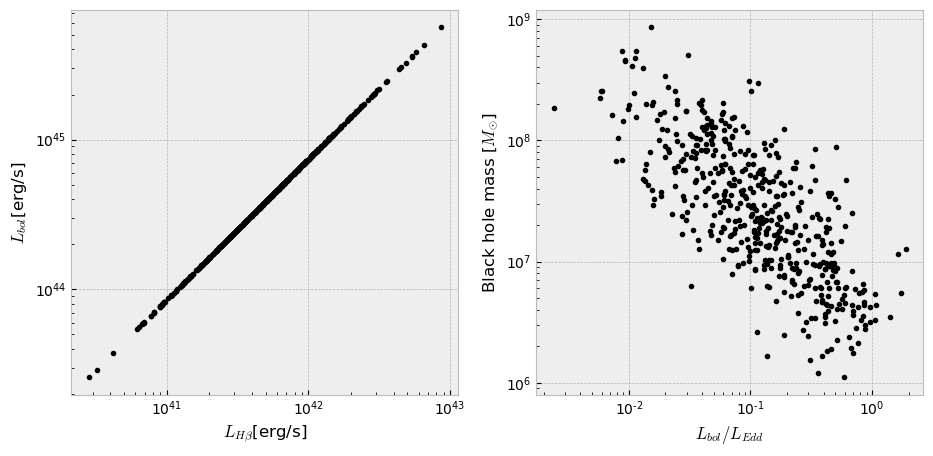

In [14]:
fig = plt.figure(figsize = (11,5))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.2)
(ax1, ax2) = gs.subplots(sharey = False)


ax1.loglog(data_SDSS['Hbeta lum'], data_SDSS['Lum bol'], '.', color = 'black')
ax1.set_xlabel(r'$L_{H \beta}$[erg/s]')
ax1.set_ylabel(r'$L_{bol}$[erg/s]')
#ax1.set_title('Wu (2009) Fig. 2 re-done with our data')

ax2.loglog(data_SDSS['Edd ratio'], data_SDSS['Mass of BH'], '.', color = 'black')
ax2.set_xlabel(r'$L_{bol}/L_{Edd}$')
ax2.set_ylabel(r'Black hole mass [$M_{\odot}$]')
#ax2.set_title('McLure & Dunlop(2002) Fig. 7 re-done with our data')
plt.show()

I have no idea why the plot on the right comes out completely opposite to the original figure. We can clearly see some linear relationship but the gradient is negative instead of positive???? (linear relationship in log-log space I mean)

### Lets compare to the original data

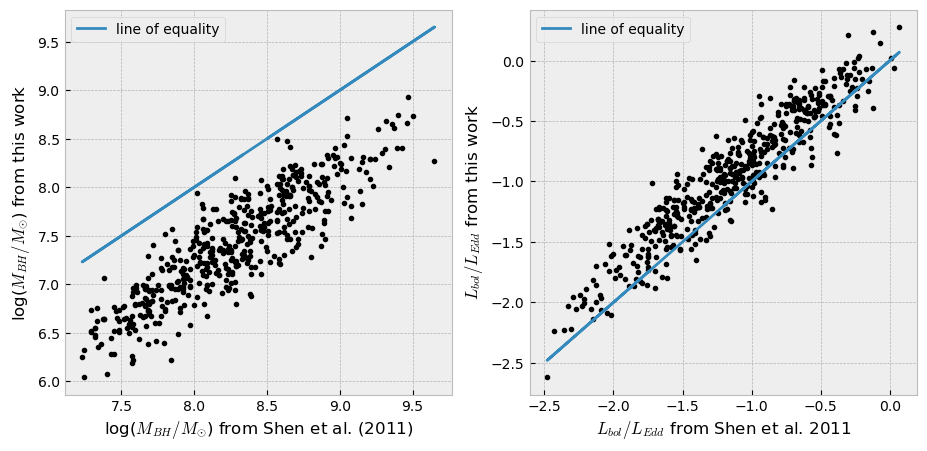

In [15]:
fig = plt.figure(figsize = (11,5))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.2)
(ax1, ax2) = gs.subplots(sharey = False)


ax1.plot(data_shen['logBH'], np.log10(data_SDSS['Mass of BH']), '.', color = 'black')
ax1.plot(data_shen['logBH'], data_shen['logBH'], label = 'line of equality')
ax1.set_xlabel(r'log($M_{BH}/M_{\odot}$) from Shen et al. (2011)')
ax1.set_ylabel(r'log($M_{BH}/M_{\odot}$) from this work')
ax1.legend()

ax2.plot(data_shen['logEdd'], np.log10(data_SDSS['Edd ratio']), '.', color = 'black')
ax2.plot(data_shen['logEdd'], data_shen['logEdd'], label = 'line of equality')
ax2.set_xlabel(r'$L_{bol}/L_{Edd}$ from Shen et al. 2011')
ax2.set_ylabel(r'$L_{bol}/L_{Edd}$ from this work')
ax2.legend()
plt.show()


We can clearly see that in our analysis we are underestimating the black hole masses, compared to Shen et al. 2011. We are also slughtly overestimating the eddington ratios but over all results seem to agree (to say that for sure we would need to do proper error analysis which is outside the scope of this tutorial :)

## Time to move on to question 2: estimating properties when we don't have BLR spectroscopy: 

In [16]:
data_wu = pd.read_csv('Wu_obj.csv')
#data_wu

In [17]:
Dl_wu = []

for index, row in data_wu.iterrows():
    dl = lum_dist(row['rvz_redshift'], omega_m, omega_l)
    Dl_wu.append(dl)
data_wu['Lum dist'] = Dl_wu


dm = 5* np.log10(data_wu['Lum dist'] * 1e6 / 10)
data_wu['Abs V mag'] = data_wu['V'] - dm
data_wu['Abs R mag'] = data_wu['R'] - dm
data_wu['Mass of BH'] =  10 ** (-0.5 * data_wu['Abs R mag'] - 2.74)

#data_wu

As a first approximation, we assume the ionizing luminosity is proportional to the visual
luminosity $L_V \approx \nu L_{\nu}(5100 \overset{\circ}{A})$. (Wandel et al. (1999)) and "in Bechtold et
al. (1987) gives a total bolometric luminosity of 1.4 times the value of νLν at 1 Rydberg, which
equals 7.7 times the value of $\nu L_{\nu}$ at 5100 ˚A" - from Wandel et al (1999). 

"We adopt Lbol = 9L5100, where L5100 = $\lambda L_{\lambda}(5100 \overset{\circ}{A})$
(Kaspi et al. 2000)" - Wu 2009 but I am unsure if this would be equal to $L_V$ since I am not sure $\lambda L_{\lambda} = \nu L_{\nu}$???

In [18]:
data_wu['Lum V'] = 10 ** (0.4 * (4.85 - data_wu['Abs V mag'])) * 3.846 * 1e33      #mult by solar lum
data_wu['Lum bol'] = 7.7 * data_wu['Lum V']
data_wu['Lum edd'] = 1.26e38 * data_wu['Mass of BH']  
data_wu['Edd ratio'] = data_wu['Lum bol']/data_wu['Lum edd']
data_wu

,oid,main_id,rvz_redshift,otype,ra,dec,U,B,V,R,Lum dist,Abs V mag,Abs R mag,Mass of BH,Lum V,Lum bol,Lum edd,Edd ratio
0,5036418,LEDA 139813,0.026598,Sy2,185.930703,-42.592231,19.45,17.280,17.75,15.690,119.988342,-17.645695,-19.705695,1.296724e+07,3.830782e+42,2.949702e+43,1.633873e+45,0.018053
1,1000586,3C 186,1.065510,QSO,116.072800,37.888125,,17.500,18.14,17.200,7333.893168,-26.186673,-27.126673,6.657887e+10,9.992599e+45,7.694301e+46,8.388938e+48,0.009172
2,285414,ICRF J182931.7+484446,0.691663,Sy1,277.382421,48.746156,,17.050,16.81,16.860,4314.470380,-26.364637,-26.314637,2.614079e+10,1.177238e+46,9.064732e+46,3.293740e+48,0.027521
3,1380415,QSO B2134+0028,1.941250,QSO,324.160776,0.698392,,17.300,17.08,17.020,15339.464720,-28.849051,-28.909051,5.182335e+11,1.160459e+47,8.935532e+47,6.529743e+49,0.013684
4,2506951,2MASX J20210438-2235183,0.185000,Sy1,305.266933,-22.590493,,17.530,16.80,16.280,926.466525,-23.034149,-23.554149,1.089116e+09,5.478589e+44,4.218514e+45,1.372287e+47,0.030741
5,3096224,2MASS J01341690-4258262,0.237134,Sy1,23.570447,-42.973951,,18.170,17.30,16.710,1223.265696,-23.137604,-23.727604,1.329848e+09,6.026302e+44,4.640252e+45,1.675608e+47,0.027693
6,1024604,3C 190,0.246390,QSO,120.389802,14.245226,,21.070,20.26,18.972,1277.443026,-20.271708,-21.559708,1.096109e+08,4.302217e+43,3.312707e+44,1.381098e+46,0.023986
7,1446666,2MASX J22502534+1419519,0.234970,Sy1,342.605615,14.331138,,17.280,16.97,17.243,1210.662157,-23.445115,-23.172115,7.015480e+08,7.999359e+44,6.159507e+45,8.839505e+46,0.069682
8,1401959,ICRF J231635.1+040518,0.220000,Sy2,349.146639,4.088416,,17.540,16.68,17.220,1124.139082,-23.574100,-23.034100,5.984807e+08,9.008436e+44,6.936495e+45,7.540856e+46,0.091986
9,290588,ICRF J234403.7+822640,0.735000,Sy2,356.015959,82.444540,,21.769,20.50,20.220,4646.690576,-22.835719,-23.115719,6.574449e+08,4.563487e+44,3.513885e+45,8.283806e+46,0.042419


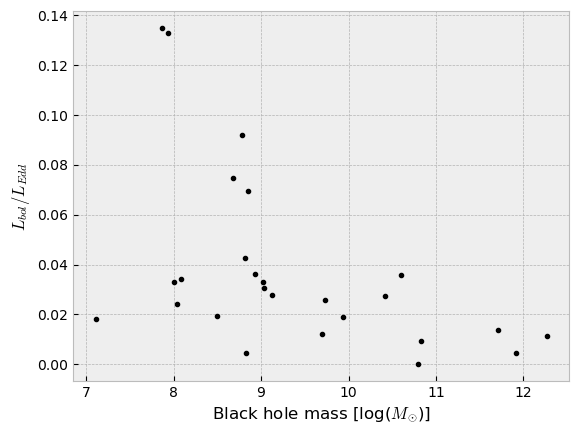

In [21]:
plt.plot(np.log10(data_wu['Mass of BH']),data_wu['Edd ratio'], '.', color = 'black')
plt.ylabel(r'$L_{bol}/L_{Edd}$')
plt.xlabel(r'Black hole mass [log($M_{\odot}$)]')
plt.show()